In [1]:
%tensorflow_version 2.x

In [2]:
import zipfile
f = zipfile.ZipFile("./drive/My Drive/train.zip")
f.extractall("./datasets")

In [3]:
import glob
catfn = glob.glob("datasets/*/cat.*")
dogfn = glob.glob("datasets/*/dog.*")
print("貓圖片共有:", len(catfn), "張")
print("狗圖片共有:", len(dogfn), "張")
catans = [0] * len(catfn)
dogans = [1] * len(dogfn)

貓圖片共有: 12500 張
狗圖片共有: 12500 張


In [4]:
import pandas as pd
datas = {
    "path":catfn + dogfn,
    "target": catans + dogans    
}
df = pd.DataFrame(datas)
df

,path,target
0,datasets/train/cat.3019.jpg,0
1,datasets/train/cat.1006.jpg,0
2,datasets/train/cat.8065.jpg,0
3,datasets/train/cat.4266.jpg,0
4,datasets/train/cat.5186.jpg,0
...,...,...
24995,datasets/train/dog.9963.jpg,1
24996,datasets/train/dog.7129.jpg,1
24997,datasets/train/dog.541.jpg,1
24998,datasets/train/dog.8467.jpg,1


#### load_img 在需要顯示圖片的時候才顯示, 減少計算量

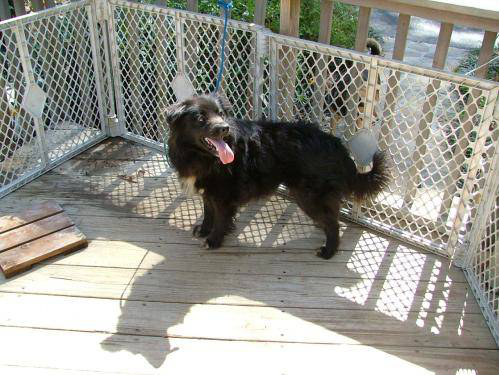

In [5]:
from tensorflow.keras.preprocessing.image import load_img
import random
import matplotlib.pyplot as plt
%matplotlib inline
p = random.randint(0, 24999)
image = load_img(df["path"][p])
image

In [6]:
# 拿 Xception
from tensorflow.keras.applications import  Xception
cnn = Xception(include_top=False, weights="imagenet", input_shape=(299, 299, 3))
cnn.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
for i in cnn.layers:
  i.trainable = False
x = BatchNormalization()(cnn.output)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.25)(x)
out = Dense(2, activation="softmax")(x)
model = Model(inputs=cnn.input, outputs=out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [8]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

In [9]:
# 訓練之前把所有 list, series  轉成 np.array
from sklearn.model_selection import train_test_split
import numpy as np
x_train, x_test, y_train, y_test = train_test_split(np.array(df["path"]),
                                                    np.array(df["target"]),
                                                    test_size=0.1)

In [10]:
# np.random.randint 可以隨機拿出多數張圖
x, y = x_train, y_train
idx = np.random.randint(0, x.shape[0], size=40)
idx

array([17045,  1418,  4080, 20995, 16377, 21742,  6984,  5711, 13316,
       12929, 16982, 10323, 17938, 18668, 15795,  1016, 17931, 11484,
       11218,  8216, 17920, 10693,  7903, 17060,  3664, 19682,   948,
        3704, 21025, 21970,  9527, 16712, 15734,   665,  5471, 18013,
        7521, 13073,  1997, 19364])

In [11]:
# x_batch 為隨機一批 x的圖,
x_batch, y_batch = x[idx], y[idx]
y_batch # 約 20 張圖片的答案

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0])

In [12]:
# 用 keras 裡面給的預處理來處理圖片, 每一個模型都有自己的處理方式內建於 keras 內
from tensorflow.keras.applications.xception import preprocess_input
# dataflow 回傳 (原圖batch, 處理後batch, 答案batch)
def dataflow(x, y, batch=20):
  idx = np.random.randint(0, x.shape[0], size=40)
  x_batch, y_batch = x[idx], y[idx]
  x_ori, x_pre = [], [] # 有些原圖還需要用, 先儲存
  for fp in x_batch:
    img = load_img(fp, target_size=(299, 299))
    img_np = np.array(img)
    x_ori.append(img_np) # 原本圖片儲存一份
    img_pre = preprocess_input(img_np)
    x_pre.append(img_pre)
  x_ori, x_pre = np.array(x_ori), np.array(x_pre)
  return (x_ori, x_pre, y_batch)
#print("原圖的情況:", x_ori.shape) # 20 張圖, 224, 224, 3
#print("預處理後的圖情況:", x_pre.shape)

#### 圖檔太大時使用批次訓練, 用 train_on_batch, 返回 ["loss", "accuracy"]
#### test_on_batch, 返回 ["val_loss", "val_accuracy"]
#### 參考: https://keras.io/zh/models/model/

In [13]:
# 開始訓練, 原圖沒用到不取名字用 _ 代替
for i in range(50):
  print("-"*10 + "目前訓練次數為:", i, "-" *10)
  _, x, y =  dataflow(x_train, y_train, batch=40)
  result = model.train_on_batch(x, y)
  print(["train"], result)
  # 驗證模型
  _, x , y = dataflow(x_test, y_test)
  result = model.test_on_batch(x, y)
  print(["validate"], result)

----------目前訓練次數為: 0 ----------
['train'] [1.914191484451294, 0.375]
['validate'] [0.5953612923622131, 0.9750000238418579]
----------目前訓練次數為: 1 ----------
['train'] [38.7608757019043, 0.4749999940395355]
['validate'] [0.01605268195271492, 1.0]
----------目前訓練次數為: 2 ----------
['train'] [7.384086608886719, 0.7250000238418579]
['validate'] [0.639419436454773, 0.875]
----------目前訓練次數為: 3 ----------
['train'] [2.9207112789154053, 0.925000011920929]
['validate'] [0.5254960656166077, 0.8999999761581421]
----------目前訓練次數為: 4 ----------
['train'] [0.9970663785934448, 0.949999988079071]
['validate'] [4.36262845993042, 0.550000011920929]
----------目前訓練次數為: 5 ----------
['train'] [5.795926094055176, 0.675000011920929]
['validate'] [1.7765623331069946, 0.75]
----------目前訓練次數為: 6 ----------
['train'] [0.8748413920402527, 0.8999999761581421]
['validate'] [3.3088855743408203, 0.675000011920929]
----------目前訓練次數為: 7 ----------
['train'] [4.711790561676025, 0.824999988079071]
['validate'] [1.70416104793

In [14]:
# 預測
model.predict(x)

array([[9.99975562e-01, 2.44616258e-05],
       [1.00000000e+00, 0.00000000e+00],
       [1.20787536e-09, 1.00000000e+00],
       [1.79685703e-05, 9.99981999e-01],
       [9.89949822e-01, 1.00502195e-02],
       [9.99607742e-01, 3.92302725e-04],
       [4.77662319e-08, 1.00000000e+00],
       [8.20152865e-15, 1.00000000e+00],
       [9.99977469e-01, 2.24924624e-05],
       [2.13279918e-06, 9.99997854e-01],
       [6.09502733e-01, 3.90497237e-01],
       [1.00000000e+00, 0.00000000e+00],
       [9.88633064e-11, 1.00000000e+00],
       [1.26206586e-15, 1.00000000e+00],
       [9.99785244e-01, 2.14807849e-04],
       [1.00000000e+00, 2.00493724e-17],
       [2.32250130e-09, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [1.03642922e-02, 9.89635646e-01],
       [9.99999523e-01, 4.59042781e-07],
       [3.21049718e-26, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [1.25746268e-14, 1.00000000e+00],
       [1.00000000e+00, 2.34214509e-10],
       [1.000000

In [15]:
timg, tx, ty = dataflow(x_test, y_test, 500)
model.evaluate(tx, ty)

2/2 [==============================] - 0s 83ms/step - loss: 0.0223 - accuracy: 1.0000


[0.022279521450400352, 1.0]

In [16]:
# model 沒有 predict_calsses, 後續會移除, 用 predict + argmin = predict_classes
# argmax 找到最值得 index, 參數  axis = 1 指每一個列找出最大值
pre = model.predict(tx).argmax(axis=1)

In [17]:
# 畫圖
trans = ["Cat", "Dog"]
idx = np.nonzero(pre != ty)[0]
# 預測錯誤的圖
false_img = timg[idx]
false_answer = ty[idx]
false_predict = pre[idx]

# 把圖變大一點才塞的下
plt.figure(figsize=(20, 10))
width = 10
height = len(false_img) // width + 1
for i, img in enumerate(false_img):
    plt.subplot(height, width, i+1)
    plt.axis("off")
    t = "[Ori]:{}\n[Pre]:{}".format(trans[false_answer[i]],
                                    trans[false_predict[i]])
    plt.title(t)
    plt.imshow(img)

<Figure size 1440x720 with 0 Axes>

#### Xception 也意外的好用  
  + val_accuracy = 1.0
#### 遷移學習 :
  + 需要把 BatchNormalization 在 Flatten之前放上, 讓資料流動更加平順
  + 如果訓練不好, 嘗試 Dropout 減少神經元
  + 由於 MLP 訓練的物件不多, 減少 MLP 層數叫好
  + 注意原本的 CNN 有沒有訓練過相似的東西, imagenet 沒有人物, model zoo 裡面可搜尋


#### 許多張大圖片時的處理方式 summary :
  + zip: 先解壓縮
  + 把貓狗圖片的路徑放入 DataFrame
  + load_img: kears 內建的圖案讀取套件
  + train_on_batch: 批次訓練 返回 ["loss", "accuracy"]
  + test_on_batch: 批次測試 返回 ["val_loss", "val_accuracy"]